In [2]:
import osmnx as ox
import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as geopy_distance
from geopy.extra.rate_limiter import RateLimiter
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import networkx as nx
import matplotlib.pyplot as plt

In [120]:
import random
# Define a function to generate random coordinates within a given radius of a central point
def generate_random_coordinates(center_lat, center_lon, radius):
    # Generate random distance and angle
    random_distance = random.random() * radius
    random_angle = random.random() * 360
    # Calculate random point coordinates using geopy.distance
    return geopy_distance(kilometers=random_distance).destination((center_lat, center_lon), bearing=random_angle)


# Initialize geolocator with a user-agent
geolocator = Nominatim(user_agent="routing-system-big-data")

# List of areas to geocode
areas = ["Titan - Balta Albă"]
radius = 2  # Radius in kilometers within which to generate house locations
num_locations_per_area = 50  # Number of locations to generate per area

# Get central coordinates of the areas
central_coordinates = {area: geolocator.geocode(area) for area in areas}
# Generate house locations
house_locations = []
for area, location in central_coordinates.items():
    if location:
        for _ in range(num_locations_per_area):
            random_coords = generate_random_coordinates(location.latitude, location.longitude, radius)
            house_locations.append((random_coords[0], random_coords[1]))

# house_locations now contains the generated coordinates for the house locations
house_locations


[(44.41275087689881, 26.185169477141642),
 (44.42187488275353, 26.15855616892296),
 (44.42030918857814, 26.16840354616331),
 (44.41412797398343, 26.16640997719442),
 (44.41933580035489, 26.18403978661196),
 (44.42347974184983, 26.182985787595175),
 (44.410094039959645, 26.166782824706143),
 (44.42757258281646, 26.154671507035598),
 (44.42495831828156, 26.153040256033407),
 (44.42708014948057, 26.18826245292428),
 (44.421653999303835, 26.17043547110889),
 (44.419137257672375, 26.170679490002595),
 (44.420410969211225, 26.16802576683917),
 (44.42003936232686, 26.186461260496866),
 (44.420540741293394, 26.18025651796653),
 (44.403420654890645, 26.166203229047195),
 (44.407643180184095, 26.170389426457255),
 (44.41472400540903, 26.156789571091814),
 (44.418465995203356, 26.15937701579166),
 (44.42745696688258, 26.149032686327086),
 (44.4382373113555, 26.166111958736234),
 (44.417711439661545, 26.166633037539704),
 (44.424119524915255, 26.156010255944942),
 (44.420274640851936, 26.168418338

MultiDiGraph with 4908 nodes and 11516 edges


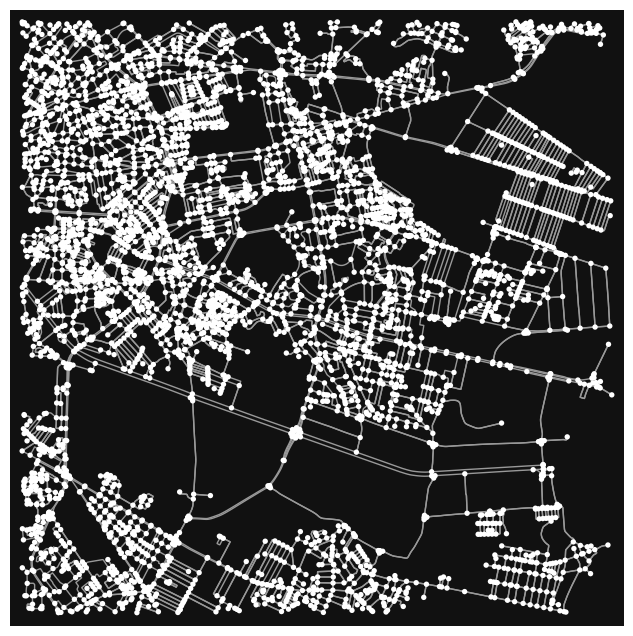

In [121]:
# Constants for the routing problem
CENTER_LOCATION = (44.413162, 26.163739)

HQ_COURIER = (44.387820, 26.168503)  # Replace with actual depot coordinates
DIST = 4000  # Adjust as needed
NUM_VEHICLES = 2  # Adjust as needed

# Get the road network graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
print(G)
*_, = ox.plot_graph(G)

MultiDiGraph with 4826 nodes and 11393 edges


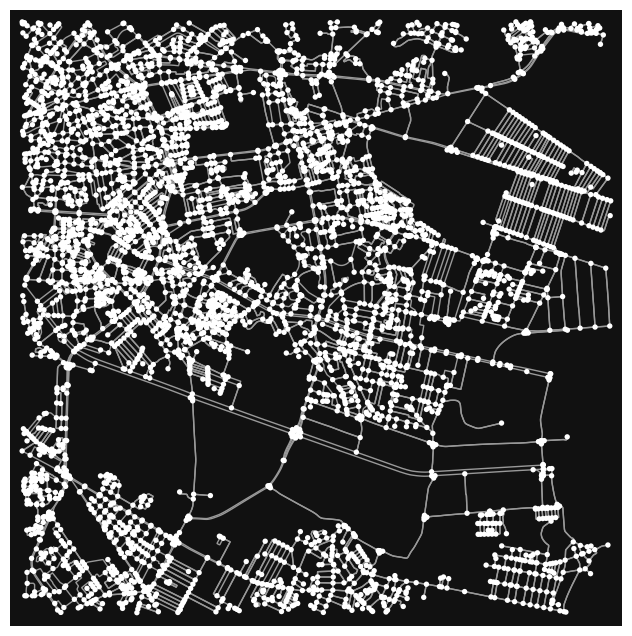

In [122]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
print(G)
*_, = ox.plot_graph(G)

In [123]:
courier_destinations = [HQ_COURIER] + house_locations
destination_nodes = [ox.nearest_nodes(G, courier_destinations[i][1], courier_destinations[i][0]) for i in range(len(courier_destinations))]

# Function to calculate distance matrix using networkx
def calculate_distance_matrix(node_destinations, G):
    distance_matrix = []
    for node1 in node_destinations:
        row = []
        for node2 in node_destinations:
            length = round(nx.shortest_path_length(G, node1, node2, weight='length'))
            row.append(length)
        distance_matrix.append(row)
    return distance_matrix


# Add depot to the list of locations and calculate the distance matrix
 
distance_matrix = calculate_distance_matrix(destination_nodes, G)


In [124]:
distance_matrix

[[0,
  5461,
  5099,
  4847,
  4527,
  5645,
  5999,
  3629,
  6096,
  5974,
  7209,
  5150,
  4659,
  4847,
  6174,
  5605,
  3164,
  3788,
  4419,
  4883,
  6371,
  6818,
  4222,
  5519,
  4847,
  4671,
  4505,
  5184,
  5939,
  7331,
  5862,
  4871,
  6072,
  5803,
  4847,
  4676,
  6419,
  3618,
  4201,
  5349,
  4686,
  4288,
  4019,
  6058,
  5937,
  5330,
  5077,
  6729,
  5129,
  4019,
  4847],
 [5411,
  0,
  3332,
  2771,
  2130,
  1404,
  1693,
  2153,
  4125,
  4021,
  2114,
  2115,
  1779,
  2771,
  1185,
  1364,
  2992,
  2183,
  2908,
  3184,
  4553,
  4267,
  2121,
  3565,
  2771,
  2972,
  2806,
  1257,
  3340,
  4043,
  1338,
  3450,
  1710,
  1612,
  2771,
  2909,
  4448,
  2320,
  3629,
  3838,
  2579,
  1846,
  1551,
  2574,
  2453,
  1815,
  2188,
  3985,
  3618,
  1551,
  2771],
 [5115,
  3176,
  0,
  1178,
  1708,
  2499,
  2288,
  1992,
  1704,
  1581,
  3680,
  1312,
  1839,
  1178,
  2540,
  2459,
  2696,
  2520,
  1629,
  1545,
  2114,
  2425,
  1194,
  1126,

In [125]:
# Create and configure the routing model
def create_model(distance_matrix, num_vehicles):

    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):

        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]


    transit_callback_index = routing.RegisterTransitCallback(distance_callback) 

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(transit_callback_index,
                          0,
                          30000, # max distance per vehicle
                          True,
                          dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    return routing, manager


In [126]:
def findBestWayNodes(G, destination_nodes) :
  # Create a directed graph for path finding
  directed_G = G.to_directed()
  current_location = destination_nodes[0]
  # Create a list to store the nodes in the path
  path_nodes = []


  # Add HQ_COURIER to the path
  path_nodes.append(current_location)

  # Iterate through the randomly selected edges
  for target_node in destination_nodes:


      # Find the shortest path from the current location to the target node
      shortest_path = nx.shortest_path(directed_G, source=current_location, target=target_node, weight='length')

      # Add the nodes in the path to the overall path_nodes list
      path_nodes.extend(shortest_path[1:])  # Exclude the starting node as it's already added

      # Update the current location to the target node for the next iteration
      current_location = target_node

  # Find the shortest path back to HQ_COURIER
  shortest_path_back = nx.shortest_path(directed_G, source=current_location, target=path_nodes[0], weight='length')

  # Add the nodes in the return path to the overall path_nodes list
  path_nodes.extend(shortest_path_back[1:])
  return path_nodes

In [127]:

# Solve the routing problem
def solve_routing_problem(routing, manager):
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        output_solution(solution, routing, manager)
    else:
        print("No solution found!")


path_nodes = []


def output_solution(solution, routing, manager):
    print("Routes:")
    total_distance = 0
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        path_nodes.append([])

        index = routing.Start(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            # plan_output += ' {} ->'.format(manager.IndexToNode(index))
            path_nodes[vehicle_id].append(destination_nodes[manager.IndexToNode(index)])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        
        plan_output = 'Distance travelled by vehicle {}: {}m\n'.format(vehicle_id, route_distance)
        path_nodes[vehicle_id].append(destination_nodes[0])
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))


# Now use these functions with your data

routing, manager = create_model(distance_matrix, NUM_VEHICLES)
solve_routing_problem(routing, manager)

Routes:
Distance travelled by vehicle 0: 25887m

Distance travelled by vehicle 1: 25846m

Total Distance of all routes: 51733m


In [128]:
path_nodes

[[6529858706,
  253729316,
  256711090,
  2400996451,
  2400993448,
  257417078,
  257332029,
  257332029,
  257332029,
  257332029,
  257332029,
  3107803636,
  257098879,
  3857227560,
  11283859277,
  3088662926,
  2197182031,
  6529858706],
 [6529858706,
  3883800307,
  2204428022,
  1839670250,
  1839670250,
  257342091,
  257341284,
  6277549497,
  257331788,
  257334329,
  2833888166,
  623667067,
  242410083,
  896331585,
  242409358,
  256703314,
  4604406920,
  256695494,
  254429475,
  479187832,
  2168853577,
  2191210751,
  257317023,
  2130269498,
  257413194,
  257413717,
  257414146,
  8178849186,
  2250946188,
  257398692,
  4282934034,
  4282934006,
  257400706,
  257338630,
  257344612,
  6529858706]]

In [129]:
color_names = [
    'red', 'orange', 'yellow', 'green', 'blue',
    'indigo', 'violet', 'purple', 'pink', 'brown',
    'maroon', 'cyan', 'teal', 'lime', 'olive',
    'navy', 'gray', 'black', 'white', 'silver'
]

colors = []
paths = []
for i in range(0, NUM_VEHICLES):
    paths.append(findBestWayNodes(G, path_nodes[i]))
    colors.append(color_names[i])
paths

[[6529858706,
  11166293713,
  11164824756,
  11165323615,
  7340559355,
  7704918531,
  2643797767,
  2643797725,
  2643797699,
  6245796093,
  256722067,
  256722077,
  2152107447,
  2152107458,
  253728913,
  253729329,
  7553414667,
  256704435,
  6028240012,
  256703884,
  253729316,
  253729312,
  256703407,
  1835544380,
  637689879,
  637689880,
  2152259469,
  256710731,
  256711092,
  256711090,
  256711092,
  256711753,
  256710733,
  635133731,
  256705985,
  242405135,
  242405378,
  660928,
  623708536,
  257336840,
  623706461,
  631145767,
  257332044,
  1427797723,
  257331789,
  257416443,
  2901560544,
  2901560550,
  2901560549,
  2447425081,
  2400996451,
  2400993448,
  2400993446,
  2400993444,
  2400993441,
  2400993442,
  2400996445,
  257417045,
  257417078,
  257416437,
  257416438,
  257416439,
  257416873,
  257416441,
  1427797722,
  631145751,
  631145767,
  257332044,
  257332039,
  257332029,
  257331788,
  6277549498,
  257333365,
  2101639412,
  25733

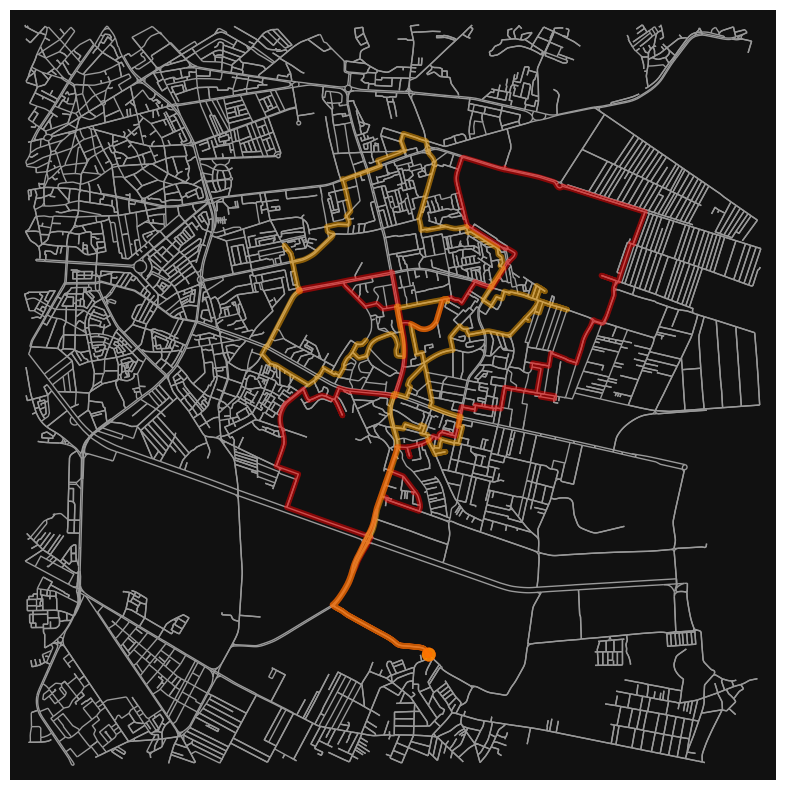

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [130]:
# Create a folium map centered around the HQ_COURIER
map_center = HQ_COURIER # Reversing the order to (latitude, longitude)
mymap = folium.Map(location=map_center, zoom_start=13)

# Plot the graph on the map
folium.Marker(location=HQ_COURIER[::-1], popup='HQ_COURIER', icon=folium.Icon(color='green')).add_to(mymap)

# Plot the routes and points for each courier
for i in range(NUM_VEHICLES):
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in paths[i]]
    folium.PolyLine(locations=route_coords, color=colors[i], weight=5, opacity=0.7).add_to(mymap)

    for node in paths[i]:
        folium.Marker(
            location=(G.nodes[node]['y'], G.nodes[node]['x']),
            popup=f'Courier {i + 1} Point',
            icon=folium.Icon(color=colors[i], icon='circle', prefix='fa')
        ).add_to(mymap)


mymap.save('couriers_map.html')

# Plot the graph with the routes highlighted in colors and display the plot
ox.plot_graph_routes(
    G,
    routes=paths,
    route_colors=colors,
    node_size=0,
    figsize=(10, 10)
)        


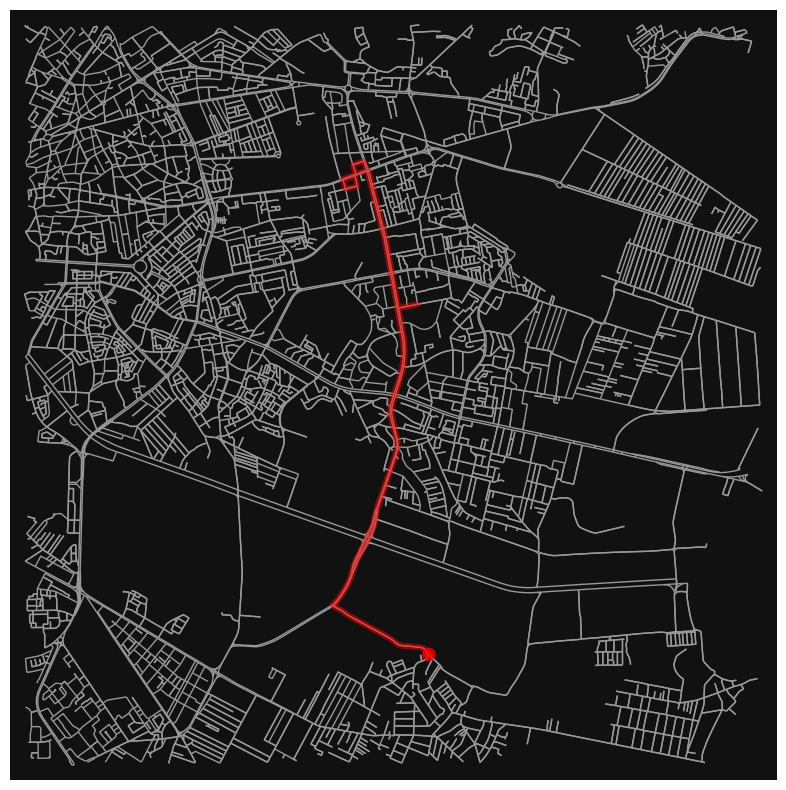

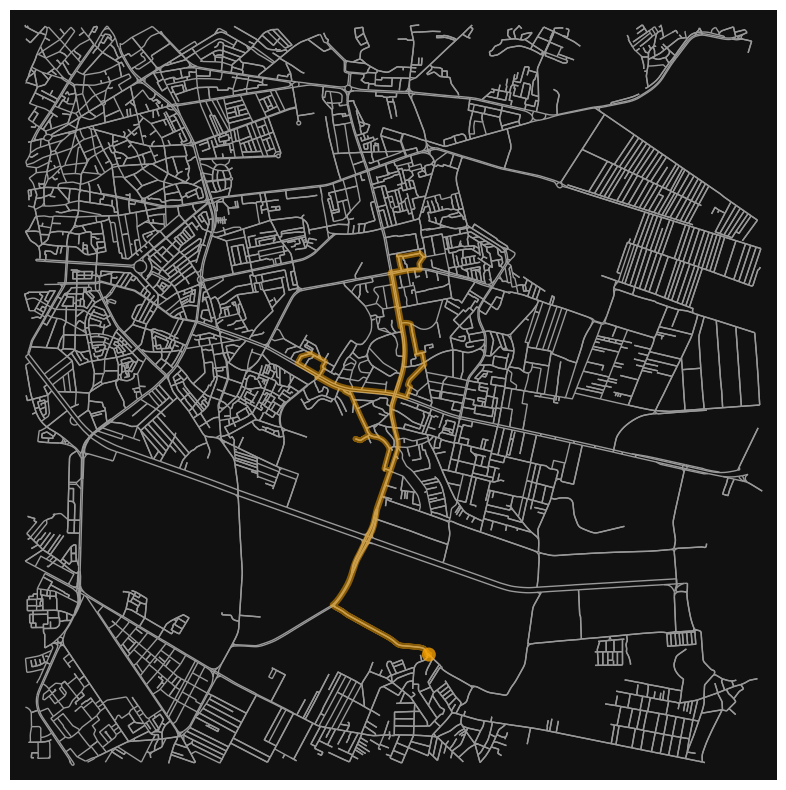

In [119]:


for i in range(0, NUM_VEHICLES):
  fig, ax = ox.plot_graph_route(G, paths[i], route_color=colors[i], node_size=0, figsize=(10, 10))
  # Add points for each edge in paths[i]
  path_points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in paths[i]]
  x, y = zip(*path_points)
  ax.scatter(x, y, color=colors[i], label=f'Courier {i + 1} Points', marker='o', s=50)

  # Display the legend
  ax.legend()
  plt.show()
